## Content
1. Load, clean and preprocess data 

2. Analyze delay data
    - Analyze departure, arrival delay versus month, day of week, hour
    - Analyze if delayed vs. origin, carrier    

3. Model delays
    - 3.1 Model if the flight is delayed
    Logistic regression
    
    - 3.2 Model if return to gate
    Logistic regression

    - 3.3 Model the arr delay vs. departure delay and other feautures (the number of flights, hour, day of week, etc)


In [33]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn. metrics import roc_auc_score, confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from itertools import cycle
from sklearn.model_selection import train_test_split
import os
%load_ext autoreload
%autoreload 2
from airline_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load, clean and preprocess data 

In [11]:

if not os.path.exists('../output/data_all'):
    data = load_data('../data/delay_tables/')
    # save it for future use
    data.to_pickle('../output/data_all')
else:
    print('found data')
    data=pd.read_pickle('../output/data_all')
    
    

found data


## 2. Analyze

## Analyze delay vs. Hour, Day, Month

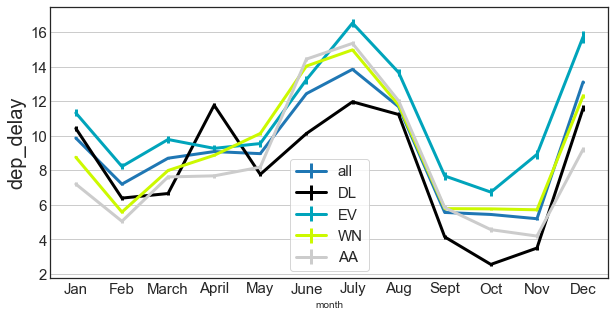

In [34]:
# plot mean + std dev vs month by carrier (from car), and for some carriers

car = ['DL','EV','WN', 'AA']
labels = ['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
plot_avg_err(data, by='carrier', of='month', y='dep_delay', labels=labels, car = ['DL','EV','WN', 'AA'])

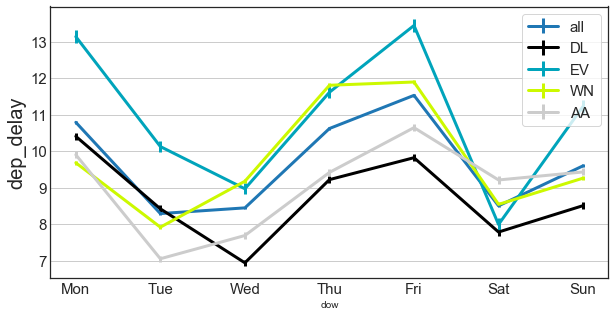

In [35]:
# plot mean + std dev vs month by carrier (from car), and for some carriers

labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plot_avg_err(data, by='carrier', of='dow', y='dep_delay', labels=labels, car = ['DL','EV','WN', 'AA'])

"\ndata['avg_speed']=(data['distance']/data['AIR_TIME']).fillna(0).astype(int)\nlabels = np.unique(data['avg_speed'])\nplot_errorbar(data, by='carrier', of='avg_speed', y='dep_delay', labels=labels)\n\ndata['duration']=(data['CRS_ELAPSED_TIME']/60).astype(int)\nlabels = np.unique((data['CRS_ELAPSED_TIME']/60).astype(int))\nplot_errorbar(data, by='carrier', of='duration', y='dep_delay', labels=labels)\n"

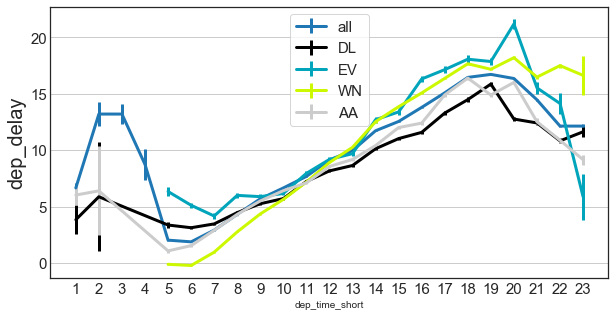

In [37]:

# plot mean + std dev vs departure time by carrier (from car), and for all carriers
labels = np.linspace(1,23, 23-1+1).astype(int)
plot_avg_err(data, by='carrier', of='dep_time_short', y='dep_delay', labels=labels, car = ['DL','EV','WN', 'AA'])

# commented because no significant results obtained
'''
data['avg_speed']=(data['distance']/data['AIR_TIME']).fillna(0).astype(int)
labels = np.unique(data['avg_speed'])
plot_errorbar(data, by='carrier', of='avg_speed', y='dep_delay', labels=labels)

data['duration']=(data['CRS_ELAPSED_TIME']/60).astype(int)
labels = np.unique((data['CRS_ELAPSED_TIME']/60).astype(int))
plot_errorbar(data, by='carrier', of='duration', y='dep_delay', labels=labels)
'''


C:\Users\monic\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


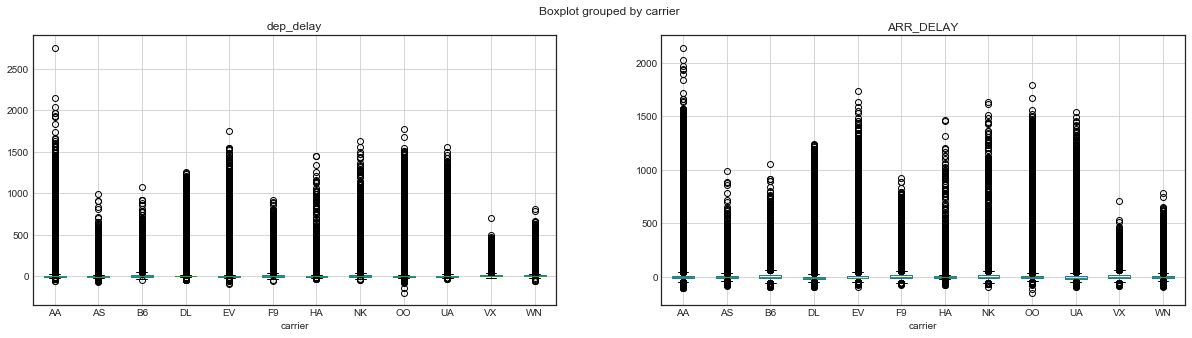

In [38]:
# barplots distribution delays by carrier

plt.figure(figsize=(20,5))
ax = plt.subplot(121)
data.boxplot('dep_delay',by='carrier',ax=ax)
ax = plt.subplot(122)
data.boxplot('ARR_DELAY',by='carrier',ax=ax)

C:\Users\monic\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


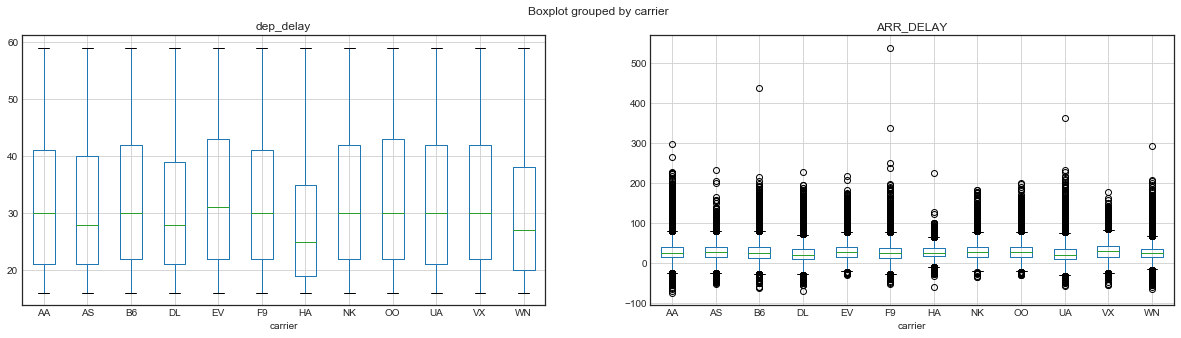

In [13]:
# barplots distribution delays (only dep delay>15, <60) by carrier

plt.figure(figsize=(20,5))
ax = plt.subplot(121)
data.loc[(data['dep_delay']>15)&(data['dep_delay']<60)].boxplot('dep_delay',by='carrier',ax=ax)
ax = plt.subplot(122)
data.loc[(data['dep_delay']>15)&(data['dep_delay']<60)].boxplot('ARR_DELAY',by='carrier',ax=ax)

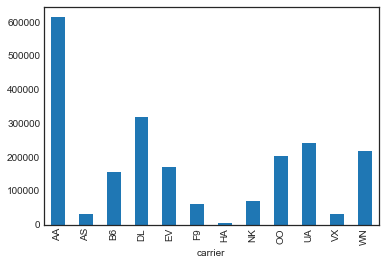

In [14]:
# barchart of #flights with  extra delay (arrival on top of departure), higher than 1h
data['extra_delay']=data['ARR_DELAY']-data['dep_delay']
data.loc[data['extra_delay']>60].groupby('carrier').agg('sum')['extra_delay'].plot.bar()

## Analyze delayed vs. dest, carrier, origin

In [ ]:
## Analyze delay types

In [16]:
import seaborn as sns

data['delay_known'] = data['SECURITY_DELAY']+data['WEATHER_DELAY']+data['CARRIER_DELAY']+data['NAS_DELAY']+data['LATE_AIRCRAFT_DELAY']
data['rest_delay'] = np.array(data['dep_delay'] - data['delay_known'])
#sns.pairplot(data[['delay_known','ARR_DELAY','dep_delay','LATE_AIRCRAFT_DELAY','NAS_DELAY','rest_delay','carrier', 'dom']].dropna(how='any'), vars =['delay_known','ARR_DELAY','dep_delay','rest_delay','LATE_AIRCRAFT_DELAY','NAS_DELAY'], hue='carrier')
#sns.heatmap(data.head()._get_numeric_data().corr())

In [18]:
data['delayed'] = data['dep_delay']>15

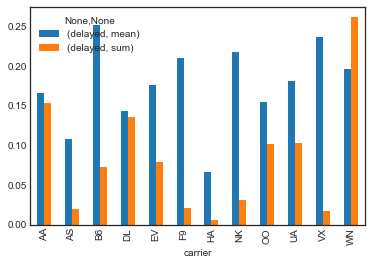

In [19]:

means = data[['carrier','delayed']].groupby('carrier').agg(['mean','sum'])

means['delayed']['sum']=means['delayed']['sum']/sum(means['delayed']['sum'])
means.plot.bar()


(0, 1.5)

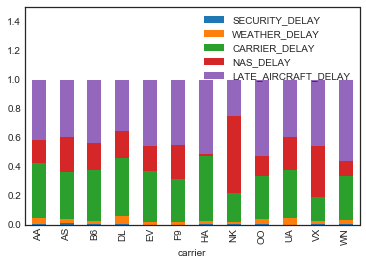

In [26]:
delays = ['SECURITY_DELAY', 'WEATHER_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY']
# normalize
for d in delays:
    data[d]=data[d]/data['delay_known']

plt.figure()
data.loc[data['dep_delay']>15,['carrier']+delays].groupby('carrier').agg('mean').plot.bar(stacked=True)
plt.ylim((0,1.5))
# unnormalize
for d in delays:
    data[d]=data[d]*data['delay_known']

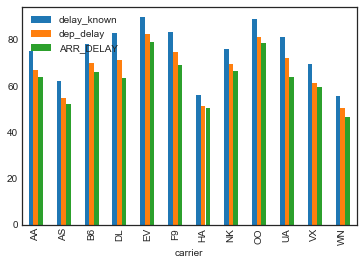

In [28]:
data.loc[data['dep_delay']>15,['delay_known','dep_delay','ARR_DELAY','carrier']].groupby('carrier').agg('mean').plot.bar()

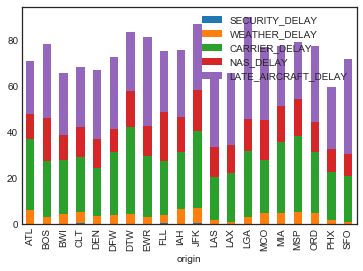

In [30]:
# plot on airports with highest delays
top = data.groupby('origin').agg('sum').sort_values(by='dep_delay',ascending=False).index[:20]
data.loc[(data['dep_delay']>15)&(data['origin'].isin(top)),['origin']+delays].groupby('origin').agg('mean').plot.bar(stacked=True)


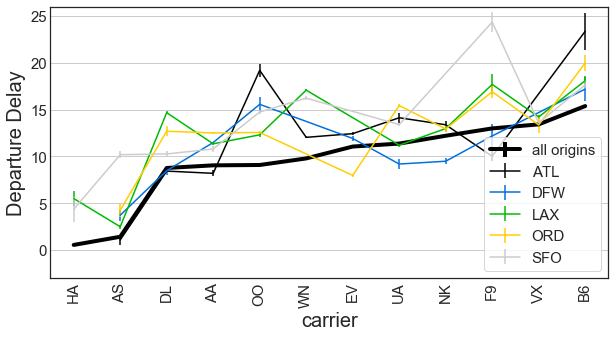

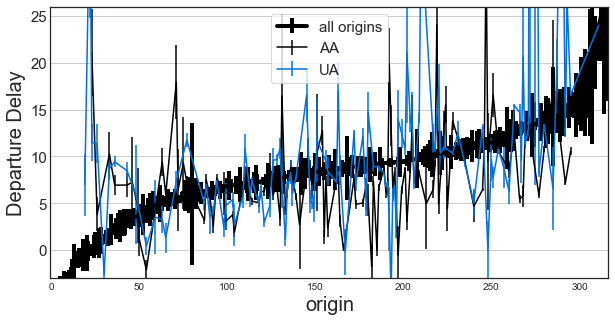

In [72]:
def plot_avg_err2(data, val, var1='carrier',var2='origin'):
    gb_aph = data[[var1,var2,'dep_delay']].groupby([var2,var1])
    mean_delays = gb_aph.agg(['mean','count','sem'])

    vals = list(mean_delays.loc[val].index)
    means = mean_delays.loc[val]['dep_delay']['mean'].values
    ss = mean_delays.loc[val]['dep_delay']['sem'].values

    N_vals = len(vals)
    vals_idx = np.zeros(N_vals)
    for i, al in enumerate(vals):
        vals_idx[i] = np.argwhere(als==al)[0][0]

    means = means[np.argsort(vals_idx)]
    ss = ss[np.argsort(vals_idx)]
    vals_idx = vals_idx[np.argsort(vals_idx)]
    return means, ss, vals_idx

# plot delay by carrier
for var1,var2 in zip(['carrier','origin'],['origin','carrier']):
    if var1 == 'carrier':
        val_var2 = np.unique(top[:5])
        show_label = True
    else:
        val_var2 = ['AA','UA']
        show_label = False
    #var1= 'carrier'
    #var2 = 'origin'
    #val_var2 = np.unique(top[:5])
    #show_label = False

    dft = data[[var1,'dep_delay']]
    dfgb = dft.groupby(var1)
    df_mean_by_al = dfgb.agg(['mean','sem','count'])
    # Get airlines sorted by mean delay
    sort_idx = np.argsort(df_mean_by_al['dep_delay']['mean'].values)
    als = np.array(list(df_mean_by_al.index))[sort_idx]
    als_means = df_mean_by_al['dep_delay']['mean'].values[sort_idx]
    als_sems = df_mean_by_al['dep_delay']['sem'].values[sort_idx]

    # Plot flight delay by airline
    N = len(als)
    plt.figure(figsize=(10,5))  
    plt.errorbar(np.arange(N),als_means,yerr=als_sems,linewidth=4,color='k',label='any '+ var2)
    m={}
    ss={}
    idx={}

    from itertools import cycle

    colors = getcmaprgb(5,cm.nipy_spectral)
    i=0
    for c in val_var2:
        m[c], ss[c], idx[c] = plot_avg_err2(data, c, var1=var1, var2=var2)
        plt.errorbar(idx[c], m[c], yerr=ss[c],color=colors[i],label=c)
        i=i+1

    plt.ylabel('Departure Delay', size=20)
    plt.xlabel(var1,size=20)
    if show_label:
        plt.xticks(np.arange(N),als[:N],size=15,rotation='vertical')
    plt.xlim((-.5,N-.5))
    plt.yticks(size=15)
    plt.legend(loc='best',fontsize=15,frameon=True)
    plt.ylim((-3,26))

    ax = plt.gca()
    ax.grid(True)
    for line in ax.get_xgridlines():
        line.set_linewidth(0)
    for line in ax.get_ygridlines():
        line.get_ydata
        line.set_linewidth(1)

## check delay known vs. dep delay and arr delay

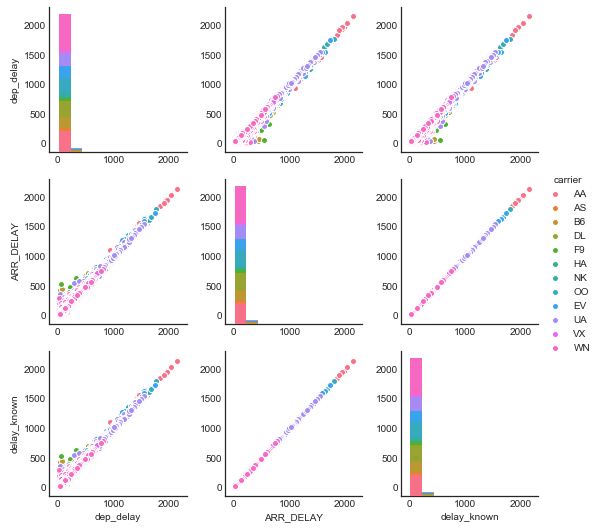

In [140]:
sns.pairplot(data.loc[data['dep_delay']>15, ['dep_delay','ARR_DELAY','delay_known','carrier']].dropna(how='any'), vars = ['dep_delay','ARR_DELAY','delay_known'], hue='carrier')

## Analyze if delayed

In [ ]:
# plot %delayed origin vs. carrier, for origins with %delayed > 30%
groups = data.groupby(['origin','carrier'])
reduced = []
for g,group in groups:
    if (len(group)>1000)&(sum(group['delayed'])>100):
        reduced.append(group)
reduced = pd.concat(reduced)
delayed = reduced.groupby(['origin','carrier'])['delayed'].agg(lambda x:sum(x)/len(x))

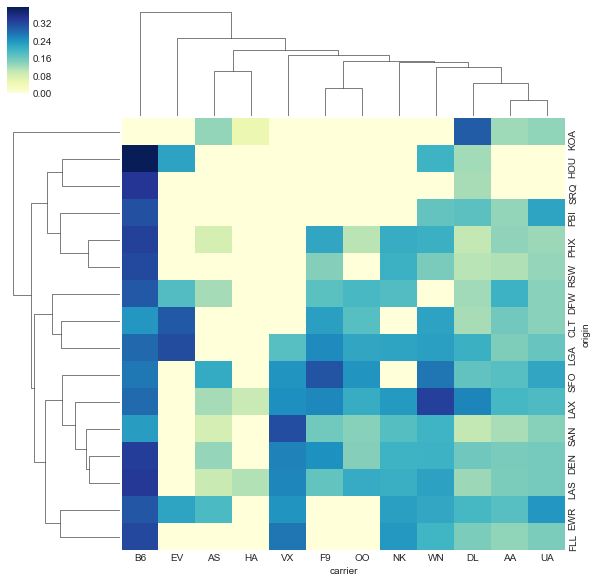

In [78]:
deldf = delayed.reset_index()
locs = np.unique(deldf.loc[deldf['delayed']>0.3,'origin'])
deldf = deldf.loc[deldf['origin'].isin(locs)]
plt.figure(figsize=(20,15))
sns.clustermap(deldf.groupby(['origin','carrier'])['delayed'].agg('mean').unstack().fillna(0),cmap='YlGnBu')

## Analyze Return to gate

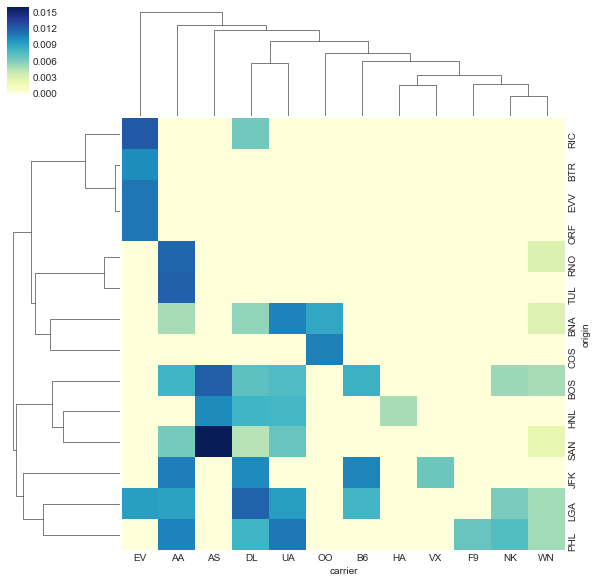

In [79]:
#data.loc[data['rtg']==True,'TOTAL_ADD_GTIME'].plot.hist(title='Total time away from gate')
groups = data.groupby(['origin','carrier'])
reduced = []
for g,group in groups:
    if (len(group)>1000)&(sum(group['rtg'])>30):
        reduced.append(group)
reduced = pd.concat(reduced)
rtg = reduced.groupby(['origin','carrier'])['rtg'].agg(lambda x:sum(x)/len(x))
rtgdf = rtg.reset_index()
locs = np.unique(rtgdf.loc[rtgdf['rtg']>0.01,'origin'])
rtgdf = rtgdf.loc[rtgdf['origin'].isin(locs)]
plt.figure(figsize=(20,15))
sns.clustermap(rtgdf.groupby(['origin','carrier'])['rtg'].agg('sum').unstack().fillna(0),cmap='YlGnBu')

## 3. Models

## 3.1. Model if delayed

In [ ]:
import pandas as pd
origins = ['ATL',
'ORD',
'DFW',
'DEN',
'LAX',
'EWR',
'PHX',
'JFK',
'SEA',
'BOS']
data = pd.read_pickle('../output/data_all')
data = data.loc[data['origin'].isin(origins)]

# Add potential new features:

# add count_flights_carrier
data = pd.merge(data,data.groupby(['carrier','origin']).agg('count').reset_index()[['carrier','origin','cancelled']].rename(columns={'cancelled':'count_flights_carrier'}),on=['carrier','origin']).copy()

# add count_flights_route
data = pd.merge(data,data.groupby(['carrier','origin','dest']).agg('count').reset_index()[['carrier','origin','dest','cancelled']].rename(columns={'cancelled':'count_flights_route'}),on=['carrier','origin','dest']).copy()

# Add the num flights origin around that time
data['approx_time']=np.round(data['dep_time_short'].astype(int)/4)
data = pd.merge(data, data.groupby(['month','dom','approx_time']).agg('count')['origin'].reset_index().rename(columns={'origin':'count_flights_origin'}),on=['month','dom','approx_time']).copy()

data['flight_hours']=(data['CRS_ELAPSED_TIME']/60).astype(int)
data['delayed']=data['dep_delay']>15
data['rtg']=(~data['TOTAL_ADD_GTIME'].isnull()) & (data['cancelled']==0)

data.reset_index(inplace=True)

In [7]:
data.to_pickle('../output/data_origins')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ATL
BOS
DEN
DFW
EWR
JFK
LAX
ORD
PHX


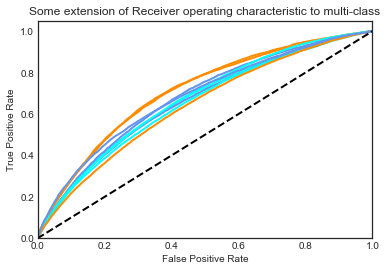

Confusion matrix, without normalization
[[402979 277480]
 [ 56872 107470]]
Normalized confusion matrix
[[0.59 0.41]
 [0.35 0.65]]


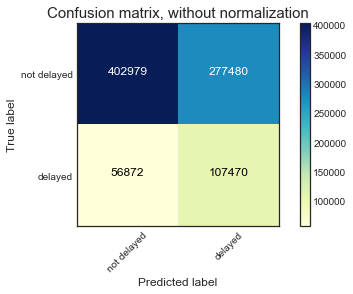

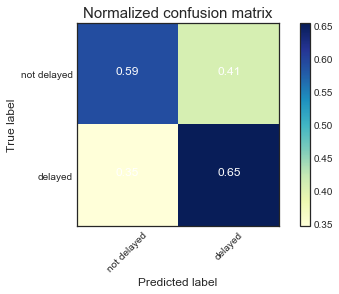

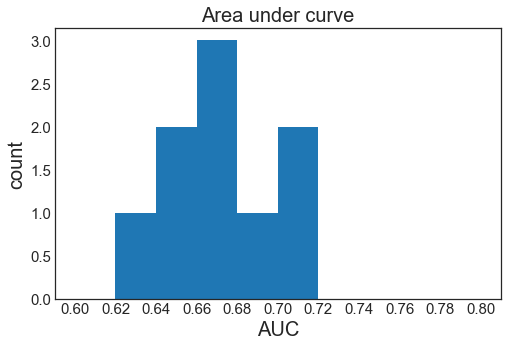

In [16]:

%load_ext autoreload
%autoreload 2
from model_delay import *

model_delayed(data)

## 3.2. Model arrival delay

                            OLS Regression Results                            
Dep. Variable:              ARR_DELAY   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     5451.
Date:                Tue, 06 Mar 2018   Prob (F-statistic):               0.00
Time:                        08:47:47   Log-Likelihood:            -2.3513e+05
No. Observations:               64307   AIC:                         4.707e+05
Df Residuals:                   64107   BIC:                         4.725e+05
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                -

R^2
0.9382681506658535
Mean abs error
6.298430014580264


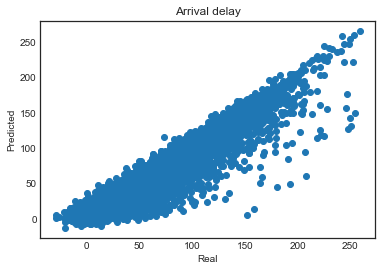

In [50]:
import statsmodels.formula.api as smf
org='ATL'
# model as categorical C(*)
cols = ['TAXI_OUT','flight_hours','month', 'dom', 'dow', 'dep_time_short', 'carrier', 'dest',
        'count_flights_carrier','count_flights_origin','count_flights_route', 'dep_delay','ARR_DELAY', 'distance']
df1 = data.loc[(data['origin']==org)&(data['dom']<21) & (data['dep_delay']>15) & (data['dep_delay']<180),cols].dropna(how='any').copy()
df2 = data.loc[(data['origin']==org)&(data['dom']>=21) & (data['dep_delay']>15) & (data['dep_delay']<180),cols].dropna(how='any').copy()
res = smf.ols(formula='ARR_DELAY ~ C(dow) + C(dep_time_short) + C(carrier) + C(dest) + dep_delay + count_flights_carrier + count_flights_origin + count_flights_route + distance + TAXI_OUT + flight_hours', data=df1).fit()

#print(res.params)
print(res.summary())
y_pred = res.predict(exog=df2.loc[df2['dest'].isin(df1['dest'])])
y_test = df2.loc[df2['dest'].isin(df1['dest']),'ARR_DELAY']

fig, ax = plt.subplots()
ax.scatter(y_test,y_pred)
print('R^2')
print(metrics.r2_score(y_test,y_pred))
plt.title('Arrival delay')
plt.xlabel('Real')
plt.ylabel('Predicted')
print('Mean abs error')
print(metrics.mean_absolute_error(y_test,y_pred))

## 3.3. Model return to gate, for location with 10 highest RTG count

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ATL
ORD
DFW
DEN
LAX
EWR
PHX
JFK
SEA
BOS


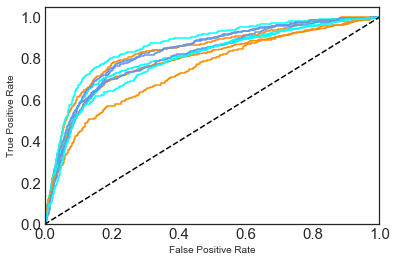

Confusion matrix, without normalization
[[124196  23541]
 [  1545   3055]]
Normalized confusion matrix
[[0.84 0.16]
 [0.34 0.66]]


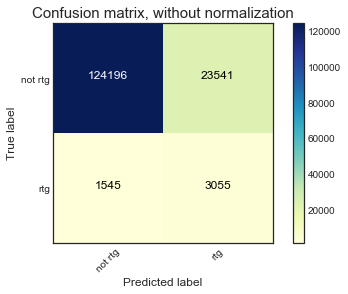

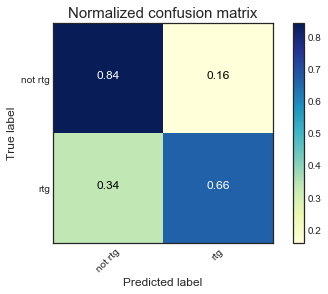

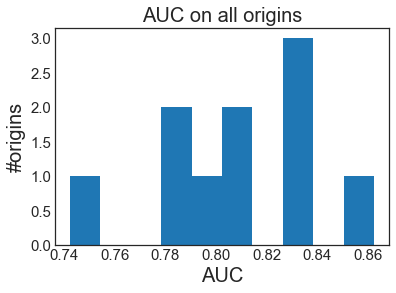

In [33]:

from model_delay import *

%load_ext autoreload
%autoreload 2

model_rtg(data)

In [55]:
%load_ext autoreload
%autoreload 2
from airline_utils import *
make_pics_transparent()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
